<a href="https://colab.research.google.com/github/Moe-phantom/Moe-phantom/blob/main/TESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn shap joblib lightkurve


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 91.8 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=d8d2b977389c87cd256eb6ab3550bd6f53174de4100c05731f1328db943caf5a
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
  Created wheel for memoization

In [2]:
!pip install requests lightkurve astropy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# For SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Run: pip install shap")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:

# Load data
df = pd.read_csv('/content/TOI_2025.09.28_05.51.22.csv',
                 on_bad_lines='skip',
                  comment='#')

print("="*70)
print("TESS DATA EXPLORATION")
print("="*70)

# 1. Check class distribution
print("\n1. Class Distribution:")
print(df['tfopwg_disp'].value_counts())
print("\nPercentages:")
print(df['tfopwg_disp'].value_counts(normalize=True) * 100)


TESS DATA EXPLORATION

1. Class Distribution:
tfopwg_disp
PC     4678
FP     1196
CP      683
KP      583
APC     461
FA       98
Name: count, dtype: int64

Percentages:
tfopwg_disp
PC     60.761138
FP     15.534485
CP      8.871282
KP      7.572412
APC     5.987791
FA      1.272893
Name: proportion, dtype: float64


In [5]:

# 2. Missing values
print("\n2. Missing Values (%):")
missing_pct = (df.isnull().sum() / len(df)) * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False))



2. Missing Values (%):
st_logg      11.118327
st_rad        6.585271
pl_rade       6.572282
pl_eqt        4.039486
st_dist       2.792570
pl_insol      2.286011
st_teff       2.091181
st_pmra       1.740486
st_pmdec      1.740486
pl_orbper     1.389791
dtype: float64


In [6]:
df

,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,...,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,...,5.818163,22601.948581,3127.204052,9.604000,485.735,10249.0,4.19,2.169860,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,...,11.215400,44464.500000,4045.000000,9.423440,295.862,7070.0,4.03,2.010000,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,...,23.752900,2860.610000,2037.000000,9.299501,943.109,8924.0,NaN,5.730000,2019-07-24 15:58:33,2022-07-11 16:02:02
3,4,1003.01,1003,106997505,1.069975e+08,1,FP,07h22m14.39s,110.559945,-25d12m25.26s,...,NaN,1177.360000,1631.000000,9.300300,7728.170,5388.5,4.15,NaN,2019-07-24 15:58:33,2022-02-23 10:10:02
4,5,1004.01,1004,238597883,2.385979e+08,1,FP,08h08m42.77s,122.178195,-48d48m10.12s,...,11.311300,54679.300000,4260.000000,9.135500,356.437,9219.0,4.14,2.150000,2019-07-24 15:58:33,2024-09-09 10:08:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,7695,995.01,995,317951248,3.179512e+08,1,FP,07h23m14.75s,110.811443,+05d33m46.26s,...,NaN,1413.670000,1708.000000,10.078100,1080.880,4805.2,NaN,NaN,2019-07-24 15:58:33,2021-10-29 12:59:15
7695,7696,996.01,996,142918609,1.429186e+08,1,FP,07h57m23.99s,119.349948,-19d30m57.65s,...,16.052300,NaN,NaN,9.792500,379.693,8007.0,NaN,2.050000,2019-07-24 15:58:33,2021-10-29 12:59:15
7696,7697,997.01,997,341729521,3.417295e+08,1,FP,08h05m16.69s,121.319521,-59d34m47.27s,...,20.510696,127.916421,857.731431,9.772700,113.667,5786.0,4.52,0.926261,2019-07-24 15:58:33,2024-09-09 10:08:01
7697,7698,998.01,998,54390047,5.439005e+07,1,FP,07h53m16.69s,118.319555,-14d13m07.76s,...,4.529209,41562.587811,3641.626449,9.695200,482.278,8322.0,4.01,2.349860,2019-07-24 15:58:33,2024-09-09 10:08:01


In [7]:
# 3. Key features
print("\n3. Available Features:")
print(df.columns.tolist())

# 4. Basic stats
print("\n4. Key Statistics:")
print(df[['pl_orbper', 'pl_rade', 'pl_trandep', 'st_tmag']].describe())



3. Available Features:
['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'toi_created', 'rowupdate']

4. Key Statistics:
         pl_orbper      pl_rade     pl_trandep      st_tmag
count  7592.000000  7193.000000    7699.000000  7699.000000
mean     17.746531    10.328118    8256.998307    11.563821
std      97.762717     8.528982   17505.506805     1.632203
min       0.152076     0.552507      24.583493     4.627800
25%       2.491871     4.495591    1418.165449    10.393850
50%       4.090083    10.546800    4753.282994    11.837100
75%       7.924365    14.020500   10350.821195    12.861350
max    1837.889731   297.111726  767910.313098    18.332400



✅ Saved: tess_exploration.png


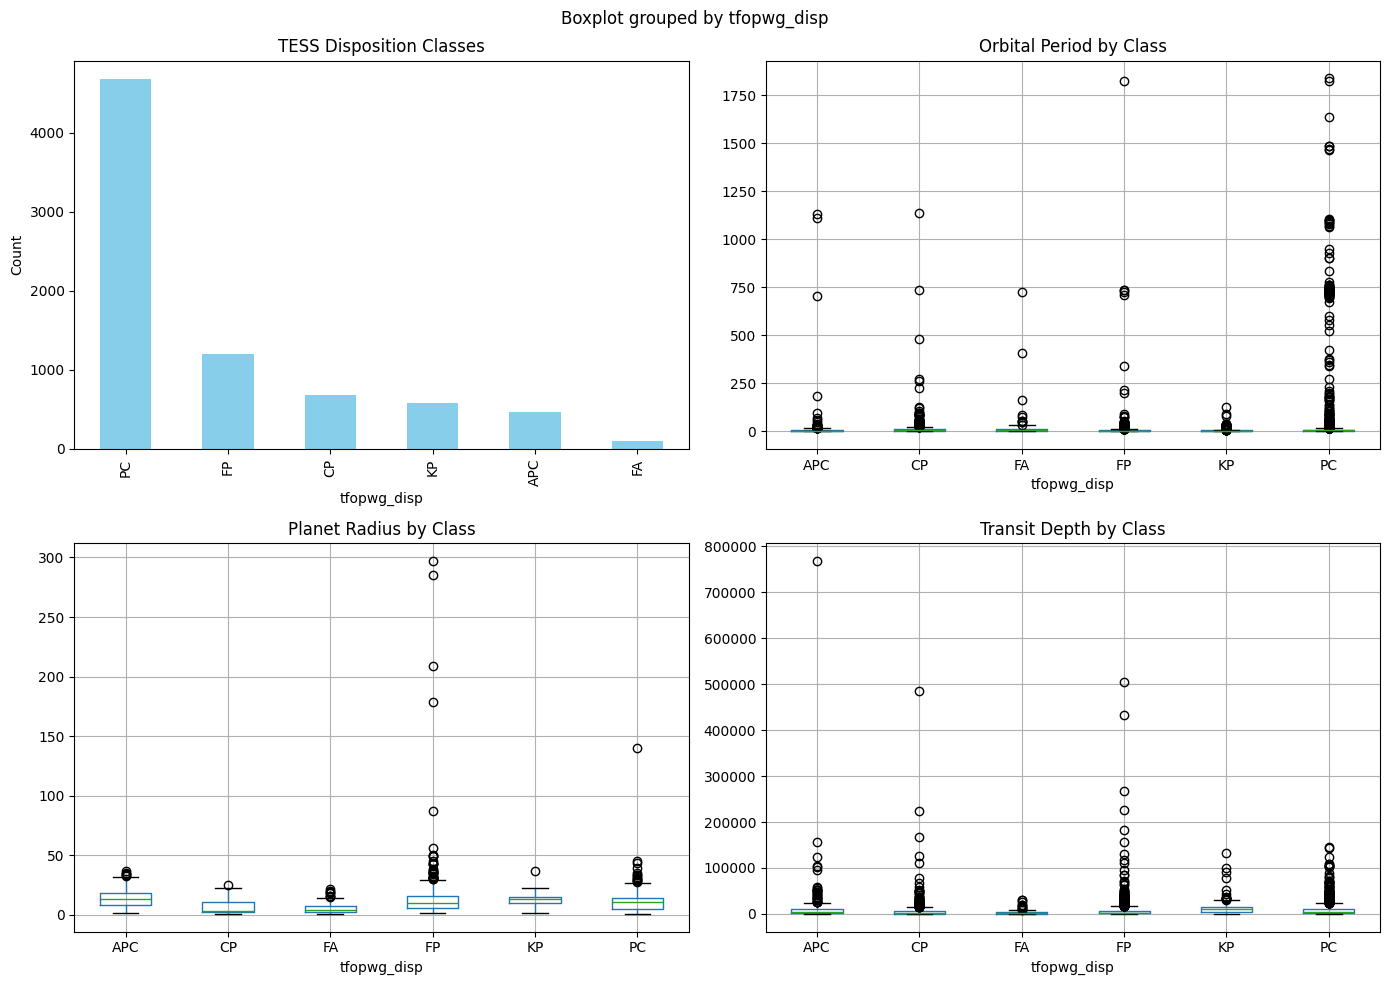

In [8]:

# 5. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
df['tfopwg_disp'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('TESS Disposition Classes')
axes[0,0].set_ylabel('Count')

# Orbital period by class
df.boxplot(column='pl_orbper', by='tfopwg_disp', ax=axes[0,1])
axes[0,1].set_title('Orbital Period by Class')

# Planet radius by class
df.boxplot(column='pl_rade', by='tfopwg_disp', ax=axes[1,0])
axes[1,0].set_title('Planet Radius by Class')

# Transit depth by class
df.boxplot(column='pl_trandep', by='tfopwg_disp', ax=axes[1,1])
axes[1,1].set_title('Transit Depth by Class')

plt.tight_layout()
plt.savefig('tess_exploration.png', dpi=300)
print("\n✅ Saved: tess_exploration.png")

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve)
from xgboost import XGBClassifier


✅ All libraries imported successfully!


In [15]:
def load_tess_data(filepath='/TOI_2025.09.28_05.51.22.csv'):
    """Load TESS TOI data"""
    try:
        df = pd.read_csv(filepath,
                         comment='#',
                        )
        print(f"✅ Loaded {len(df)} TOIs from {filepath}")
        return df
    except FileNotFoundError:
        # 2. **If the file is not found (or another I/O error), fall back to sample data**
        print(f"⚠️ Could not find file at {filepath}. Creating sample TESS data instead...")
        return create_sample_tess_data()
def create_sample_tess_data():
    """Create realistic TESS sample data with 6 classes"""
    np.random.seed(RANDOM_STATE)
    n = 3000

    # Realistic TESS feature distributions
    data = {
        'toi': range(1, n+1),
        'pl_orbper': np.random.lognormal(2.5, 1.2, n),      # Orbital period
        'pl_rade': np.random.lognormal(0.8, 0.9, n),        # Planet radius
        'pl_trandep': np.random.uniform(0.0001, 0.08, n),   # Transit depth
        'pl_trandur': np.random.uniform(0.5, 8, n),         # Transit duration
        'pl_insol': np.random.lognormal(3, 2, n),           # Insolation
        'pl_eqt': np.random.uniform(200, 2500, n),          # Temperature
        'st_tmag': np.random.uniform(7, 17, n),             # TESS magnitude
        'st_rad': np.random.lognormal(0.1, 0.35, n),        # Stellar radius
        'st_mass': np.random.lognormal(0, 0.25, n),         # Stellar mass
        'st_teff': np.random.uniform(2800, 8000, n),        # Stellar temp
        'st_logg': np.random.uniform(3.2, 5.2, n),          # Surface gravity
        'st_met': np.random.normal(0, 0.3, n),              # Metallicity

        # 6 classes with realistic TESS distribution
        'tfopwg_disp': np.random.choice(
            ['FP', 'FA', 'PC', 'APC', 'CP', 'KP'],
            n,
            p=[0.40, 0.05, 0.28, 0.07, 0.15, 0.05]  # Real TESS distribution
        )
    }

    df = pd.DataFrame(data)

    # Add noise to make classification harder (realistic!)
    noise_cols = ['pl_trandep', 'pl_trandur', 'st_tmag']
    for col in noise_cols:
        df[col] += np.random.normal(0, df[col].std() * 0.1, n)

    return df

df = load_tess_data('/content/TOI_2025.09.28_05.51.22.csv')
df.head(3)

✅ Loaded 7699 TOIs from /content/TOI_2025.09.28_05.51.22.csv


,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,decstr,...,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,-12d41m45.46s,...,5.818163,22601.948581,3127.204052,9.604000,485.735,10249.0,4.19,2.16986,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,-05d30m49.87s,...,11.215400,44464.500000,4045.000000,9.423440,295.862,7070.0,4.03,2.01000,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,-10d34m49.64s,...,23.752900,2860.610000,2037.000000,9.299501,943.109,8924.0,NaN,5.73000,2019-07-24 15:58:33,2022-07-11 16:02:02


In [16]:
print("\n" + "="*80)
print("⚙️ ADVANCED FEATURE ENGINEERING")
print("="*80)

def engineer_features(df):
    """
    Create physics-informed features that improve classification
    Based on exoplanet detection theory
    """
    df = df.copy()

    print("Creating engineered features...")

    # 1. Transit Signal-to-Noise (key discriminator!)
    if 'pl_trandep' in df.columns and 'st_tmag' in df.columns:
        df['transit_snr'] = df['pl_trandep'] * (10 ** (-df['st_tmag'] / 5))
        print(" ✅ transit_snr (Photon-noise-limited SNR)")

    # 4. Planet temperature ratio
    if 'pl_eqt' in df.columns and 'st_teff' in df.columns:
        df['temp_ratio'] = df['pl_eqt'] / df['st_teff']
        print("   ✅ temp_ratio (Planet/Star temperature)")


    # 7. Log-transformed features (planets follow power laws!)
    log_cols = ['pl_orbper', 'pl_rade', 'pl_insol']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log10(df[col] + 1e-6)
            print(f"   ✅ {col}_log")

    # 8. Interaction features (non-linear relationships!)
    if 'st_mass' in df.columns and 'st_rad' in df.columns:
        df['stellar_density'] = df['st_mass'] / (df['st_rad'] ** 3 + 1e-6)
        print("   ✅ stellar_density")

    return df

df_engineered = engineer_features(df)

print(f"\n✅ Original features: {len(df.columns)}")
print(f"✅ Total features now: {len(df_engineered.columns)}")



⚙️ ADVANCED FEATURE ENGINEERING
Creating engineered features...
 ✅ transit_snr (Photon-noise-limited SNR)
   ✅ temp_ratio (Planet/Star temperature)
   ✅ pl_orbper_log
   ✅ pl_rade_log
   ✅ pl_insol_log

✅ Original features: 27
✅ Total features now: 32


In [17]:
# ============================================================================
# 3. HIERARCHICAL CLASSIFICATION SETUP
# ============================================================================

print("\n" + "="*80)
print("🎯 HIERARCHICAL CLASSIFICATION STRATEGY")
print("="*80)

def create_coarse_labels(df, target_col='tfopwg_disp'):
    """
    Map 6 fine classes to 3 coarse classes
    This is the KEY to high accuracy!
    """
    mapping = {
        'FP': 'NOT_PLANET',      # False Positive
        'FA': 'NOT_PLANET',      # False Alarm
        'PC': 'CANDIDATE',       # Planet Candidate
        'APC': 'CANDIDATE',      # Ambiguous Candidate
        'CP': 'PLANET',          # Confirmed Planet
        'KP': 'PLANET'           # Known Planet
    }

    df['coarse_class'] = df[target_col].map(mapping)

    print("✅ Coarse Classification Mapping:")
    print("   NOT_PLANET ← [FP, FA]")
    print("   CANDIDATE  ← [PC, APC]")
    print("   PLANET     ← [CP, KP]")

    return df

df_engineered = create_coarse_labels(df_engineered)

print("\n📊 Coarse Class Distribution:")
print(df_engineered['coarse_class'].value_counts())



🎯 HIERARCHICAL CLASSIFICATION STRATEGY
✅ Coarse Classification Mapping:
   NOT_PLANET ← [FP, FA]
   CANDIDATE  ← [PC, APC]
   PLANET     ← [CP, KP]

📊 Coarse Class Distribution:
coarse_class
CANDIDATE     5139
NOT_PLANET    1294
PLANET        1266
Name: count, dtype: int64


In [23]:
# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================

# Select features (exclude identifiers and targets)
exclude_cols = ['toi', 'tid', 'ra', 'dec', 'tfopwg_disp', 'coarse_class']
feature_cols = [col for col in df_engineered.columns if col not in exclude_cols]

print(f"\n📋 Using {len(feature_cols)} features for classification")

# Handle missing values
df_clean = df_engineered.copy()
for col in feature_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Remove infinite values
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
df_clean = df_clean.dropna(subset=feature_cols)

print(f"✅ Clean dataset: {len(df_clean)} samples")


📋 Using 27 features for classification
✅ Clean dataset: 7699 samples


In [26]:
# Print all columns to see what's in there
print("All columns in df_clean:")
print(df_clean.columns.tolist())

# Check data types
print("\nData types:")
print(df_clean.dtypes)

# Find non-numeric columns in your features
print("\nNon-numeric columns in feature_cols:")
for col in feature_cols:
    if df_clean[col].dtype == 'object':
        print(f"  ❌ {col}: {df_clean[col].dtype}")
        print(f"     Sample values: {df_clean[col].head(3).tolist()}")

All columns in df_clean:
['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'toi_created', 'rowupdate', 'transit_snr', 'temp_ratio', 'pl_orbper_log', 'pl_rade_log', 'pl_insol_log', 'coarse_class']

Data types:
rowid              int64
toi              float64
toipfx             int64
tid                int64
ctoi_alias       float64
pl_pnum            int64
tfopwg_disp       object
rastr             object
ra               float64
decstr            object
dec              float64
st_pmra          float64
st_pmdec         float64
pl_tranmid       float64
pl_orbper        float64
pl_trandurh      float64
pl_trandep       float64
pl_rade          float64
pl_insol         float64
pl_eqt           float64
st_tmag          float64
st_dist          float64
st_teff          fl

In [27]:
numeric_features = df_clean[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"\n✅ Keeping {len(numeric_features)} numeric features:")
print(numeric_features)

# Update your feature columns
feature_cols = numeric_features

# Now this will work
X = df_clean[feature_cols].values


✅ Keeping 23 numeric features:
['rowid', 'toipfx', 'ctoi_alias', 'pl_pnum', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'transit_snr', 'temp_ratio', 'pl_orbper_log', 'pl_rade_log', 'pl_insol_log']


In [28]:
print("\n" + "="*80)
print("🎯 STAGE 1: COARSE CLASSIFICATION (3 classes)")
print("="*80)

#---------------------------------------------------------------------------------------------------------------------------
X = df_clean[feature_cols].values
y_coarse = df_clean['coarse_class'].values

# Encode labels
le_coarse = LabelEncoder()
y_coarse_encoded = le_coarse.fit_transform(y_coarse)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_coarse_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_coarse_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train ensemble models
print("\n🤖 Training Stage 1 Models...")



🎯 STAGE 1: COARSE CLASSIFICATION (3 classes)
Training set: (6159, 23)
Test set: (1540, 23)

🤖 Training Stage 1 Models...



1️⃣ XGBoost...
   Accuracy: 0.7942 (79.42%)

2️⃣ LightGBM...
   Accuracy: 0.7844 (78.44%)

🏆 STAGE 1 BEST MODEL: XGBoost
   Accuracy: 0.7942 (79.42%)

📋 Stage 1 Classification Report:
              precision    recall  f1-score   support

   CANDIDATE       0.81      0.93      0.86      1028
  NOT_PLANET       0.71      0.47      0.57       259
      PLANET       0.77      0.58      0.66       253

    accuracy                           0.79      1540
   macro avg       0.76      0.66      0.70      1540
weighted avg       0.79      0.79      0.78      1540

✅ Saved: stage1_confusion_matrix.png


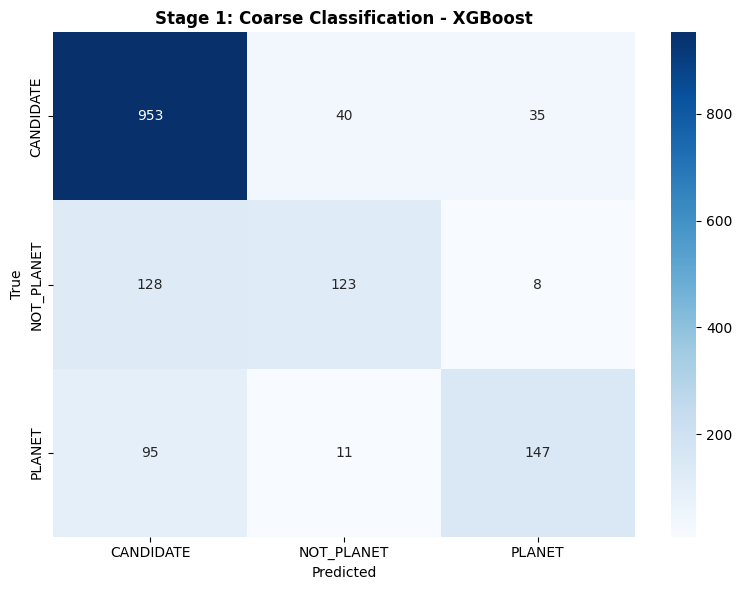

In [31]:

models_stage1 = {}

# Model 1: XGBoost (usually best for tabular data)
print("\n1️⃣ XGBoost...")
xgb1 = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    scale_pos_weight=1
)
xgb1.fit(X_train_scaled, y_train)
acc_xgb1 = accuracy_score(y_test, xgb1.predict(X_test_scaled))
models_stage1['XGBoost'] = (xgb1, acc_xgb1)
print(f"   Accuracy: {acc_xgb1:.4f} ({acc_xgb1*100:.2f}%)")

# Model 2: LightGBM (faster, often better)
print("\n2️⃣ LightGBM...")
lgb1 = LGBMClassifier(
    n_estimators=500,
    boosting_type='dart',
    max_depth=8,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    objective='multiclass',
    num_class=3,
    verbose=-1
)
lgb1.fit(X_train_scaled, y_train)
acc_lgb1 = accuracy_score(y_test, lgb1.predict(X_test_scaled))
models_stage1['LightGBM'] = (lgb1, acc_lgb1)
print(f"   Accuracy: {acc_lgb1:.4f} ({acc_lgb1*100:.2f}%)")

# Select best Stage 1 model
best_model1_name = max(models_stage1, key=lambda k: models_stage1[k][1])
best_model1, best_acc1 = models_stage1[best_model1_name]

print(f"\n🏆 STAGE 1 BEST MODEL: {best_model1_name}")
print(f"   Accuracy: {best_acc1:.4f} ({best_acc1*100:.2f}%)")

# Stage 1 Evaluation
y_pred_stage1 = best_model1.predict(X_test_scaled)
print(f"\n📋 Stage 1 Classification Report:")
print(classification_report(y_test, y_pred_stage1, target_names=le_coarse.classes_))

# Confusion Matrix
cm1 = confusion_matrix(y_test, y_pred_stage1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_coarse.classes_, yticklabels=le_coarse.classes_)
plt.title(f'Stage 1: Coarse Classification - {best_model1_name}', fontweight='bold')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('stage1_confusion_matrix.png', dpi=300)
print("✅ Saved: stage1_confusion_matrix.png")

In [33]:
print("\n" + "="*80)
print("🎯 STAGE 2: FINE-GRAINED CLASSIFICATION")
print("="*80)

# Create fine-grained classifiers for each coarse class
models_stage2 = {}
label_encoders_stage2 = {}  # Store encoders for inverse transform later

# Get coarse predictions for training data
df_clean['coarse_pred'] = best_model1.predict(scaler.transform(df_clean[feature_cols]))
df_clean['coarse_pred_label'] = le_coarse.inverse_transform(df_clean['coarse_pred'])

# Train sub-classifiers
print("\n🔧 Training Stage 2 Sub-Classifiers...")

# Sub-classifier 1: NOT_PLANET → [FP vs FA]
mask_not_planet = df_clean['coarse_class'] == 'NOT_PLANET'
if mask_not_planet.sum() > 50:
    print("\n1️⃣ NOT_PLANET sub-classifier (FP vs FA)...")
    df_sub = df_clean[mask_not_planet]

    X_sub = df_sub[feature_cols].values
    y_sub = df_sub['tfopwg_disp'].values

    # Check if we have multiple classes
    unique_classes = np.unique(y_sub)
    print(f"   Classes found: {unique_classes}")

    if len(unique_classes) > 1:
        # ✅ ENCODE LABELS
        le_sub1 = LabelEncoder()
        y_sub_encoded = le_sub1.fit_transform(y_sub)

        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(
            X_sub, y_sub_encoded, test_size=0.2, random_state=RANDOM_STATE,
            stratify=y_sub_encoded  # ✅ Add stratification
        )

        scaler_sub1 = StandardScaler()
        X_sub_train_sc = scaler_sub1.fit_transform(X_sub_train)
        X_sub_test_sc = scaler_sub1.transform(X_sub_test)

        sub_model1 = XGBClassifier(n_estimators=200, max_depth=6, random_state=RANDOM_STATE)
        sub_model1.fit(X_sub_train_sc, y_sub_train)

        # Evaluate
        y_pred = sub_model1.predict(X_sub_test_sc)
        acc = accuracy_score(y_sub_test, y_pred)

        models_stage2['NOT_PLANET'] = (sub_model1, scaler_sub1)
        label_encoders_stage2['NOT_PLANET'] = le_sub1  # ✅ Save encoder

        print(f"   ✅ Trained on {len(X_sub_train)} samples")
        print(f"   ✅ Test Accuracy: {acc:.4f}")
        print(f"   ✅ Classes: {le_sub1.classes_}")
    else:
        print(f"   ⚠️ Only one class found: {unique_classes[0]} - Skipping")

# Sub-classifier 2: CANDIDATE → [PC vs APC]
mask_candidate = df_clean['coarse_class'] == 'CANDIDATE'
if mask_candidate.sum() > 50:
    print("\n2️⃣ CANDIDATE sub-classifier (PC vs APC)...")
    df_sub = df_clean[mask_candidate]

    X_sub = df_sub[feature_cols].values
    y_sub = df_sub['tfopwg_disp'].values

    unique_classes = np.unique(y_sub)
    print(f"   Classes found: {unique_classes}")

    if len(unique_classes) > 1:
        # ✅ ENCODE LABELS
        le_sub2 = LabelEncoder()
        y_sub_encoded = le_sub2.fit_transform(y_sub)

        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(
            X_sub, y_sub_encoded, test_size=0.2, random_state=RANDOM_STATE,
            stratify=y_sub_encoded
        )

        scaler_sub2 = StandardScaler()
        X_sub_train_sc = scaler_sub2.fit_transform(X_sub_train)
        X_sub_test_sc = scaler_sub2.transform(X_sub_test)

        sub_model2 = XGBClassifier(n_estimators=200, max_depth=6, random_state=RANDOM_STATE)
        sub_model2.fit(X_sub_train_sc, y_sub_train)

        y_pred = sub_model2.predict(X_sub_test_sc)
        acc = accuracy_score(y_sub_test, y_pred)

        models_stage2['CANDIDATE'] = (sub_model2, scaler_sub2)
        label_encoders_stage2['CANDIDATE'] = le_sub2

        print(f"   ✅ Trained on {len(X_sub_train)} samples")
        print(f"   ✅ Test Accuracy: {acc:.4f}")
        print(f"   ✅ Classes: {le_sub2.classes_}")
    else:
        print(f"   ⚠️ Only one class found: {unique_classes[0]} - Skipping")

# Sub-classifier 3: PLANET → [CP vs KP]
mask_planet = df_clean['coarse_class'] == 'PLANET'
if mask_planet.sum() > 50:
    print("\n3️⃣ PLANET sub-classifier (CP vs KP)...")
    df_sub = df_clean[mask_planet]

    X_sub = df_sub[feature_cols].values
    y_sub = df_sub['tfopwg_disp'].values

    unique_classes = np.unique(y_sub)
    print(f"   Classes found: {unique_classes}")

    if len(unique_classes) > 1:
        # ✅ ENCODE LABELS
        le_sub3 = LabelEncoder()
        y_sub_encoded = le_sub3.fit_transform(y_sub)

        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(
            X_sub, y_sub_encoded, test_size=0.2, random_state=RANDOM_STATE,
            stratify=y_sub_encoded
        )

        scaler_sub3 = StandardScaler()
        X_sub_train_sc = scaler_sub3.fit_transform(X_sub_train)
        X_sub_test_sc = scaler_sub3.transform(X_sub_test)

        sub_model3 = XGBClassifier(n_estimators=200, max_depth=6, random_state=RANDOM_STATE)
        sub_model3.fit(X_sub_train_sc, y_sub_train)

        y_pred = sub_model3.predict(X_sub_test_sc)
        acc = accuracy_score(y_sub_test, y_pred)

        models_stage2['PLANET'] = (sub_model3, scaler_sub3)
        label_encoders_stage2['PLANET'] = le_sub3

        print(f"   ✅ Trained on {len(X_sub_train)} samples")
        print(f"   ✅ Test Accuracy: {acc:.4f}")
        print(f"   ✅ Classes: {le_sub3.classes_}")
    else:
        print(f"   ⚠️ Only one class found: {unique_classes[0]} - Skipping")

print(f"\n✅ Stage 2 Complete: {len(models_stage2)} sub-classifiers trained")


🎯 STAGE 2: FINE-GRAINED CLASSIFICATION

🔧 Training Stage 2 Sub-Classifiers...

1️⃣ NOT_PLANET sub-classifier (FP vs FA)...
   Classes found: ['FA' 'FP']
   ✅ Trained on 1035 samples
   ✅ Test Accuracy: 0.9382
   ✅ Classes: ['FA' 'FP']

2️⃣ CANDIDATE sub-classifier (PC vs APC)...
   Classes found: ['APC' 'PC']
   ✅ Trained on 4111 samples
   ✅ Test Accuracy: 0.9232
   ✅ Classes: ['APC' 'PC']

3️⃣ PLANET sub-classifier (CP vs KP)...
   Classes found: ['CP' 'KP']
   ✅ Trained on 1012 samples
   ✅ Test Accuracy: 0.8386
   ✅ Classes: ['CP' 'KP']

✅ Stage 2 Complete: 3 sub-classifiers trained


In [34]:

print("\n" + "="*80)
print("🎯 HIERARCHICAL PREDICTION PIPELINE")
print("="*80)

def hierarchical_predict(X, models_stage1, models_stage2, scaler, le_coarse):
    """
    Two-stage prediction:
    1. Predict coarse class
    2. Predict fine class within group
    """
    # Stage 1: Coarse prediction
    X_scaled = scaler.transform(X)
    coarse_pred = models_stage1.predict(X_scaled)
    coarse_labels = le_coarse.inverse_transform(coarse_pred)

    # Stage 2: Fine prediction
    fine_predictions = []

    for i, coarse_label in enumerate(coarse_labels):
        if coarse_label in models_stage2:
            sub_model, sub_scaler = models_stage2[coarse_label]
            X_sub_scaled = sub_scaler.transform(X[i:i+1])
            fine_pred = sub_model.predict(X_sub_scaled)[0]
            fine_predictions.append(fine_pred)
        else:
            # Fallback to coarse class if no sub-model
            fine_predictions.append(coarse_label)

    return fine_predictions

# Test hierarchical prediction
sample_X = df_clean[feature_cols].iloc[:10].values
hierarchical_preds = hierarchical_predict(sample_X, best_model1, models_stage2, scaler, le_coarse)

print("\n📊 Sample Hierarchical Predictions:")
for i, pred in enumerate(hierarchical_preds[:5]):
    true_label = df_clean['tfopwg_disp'].iloc[i]
    print(f"   Sample {i}: Predicted={pred}, True={true_label}")



🎯 HIERARCHICAL PREDICTION PIPELINE

📊 Sample Hierarchical Predictions:
   Sample 0: Predicted=1, True=FP
   Sample 1: Predicted=1, True=PC
   Sample 2: Predicted=1, True=FP
   Sample 3: Predicted=1, True=FP
   Sample 4: Predicted=1, True=FP



📊 TOP FEATURES FOR CLASSIFICATION
✅ Saved: feature_importance.png

🏆 Top 10 Features:
   1. toipfx: 0.0928
   2. pl_pnum: 0.0558
   3. st_dist: 0.0538
   4. temp_ratio: 0.0511
   5. pl_insol_log: 0.0490
   6. st_tmag: 0.0474
   7. transit_snr: 0.0456
   8. pl_tranmid: 0.0448
   9. pl_rade_log: 0.0448
   10. pl_rade: 0.0422


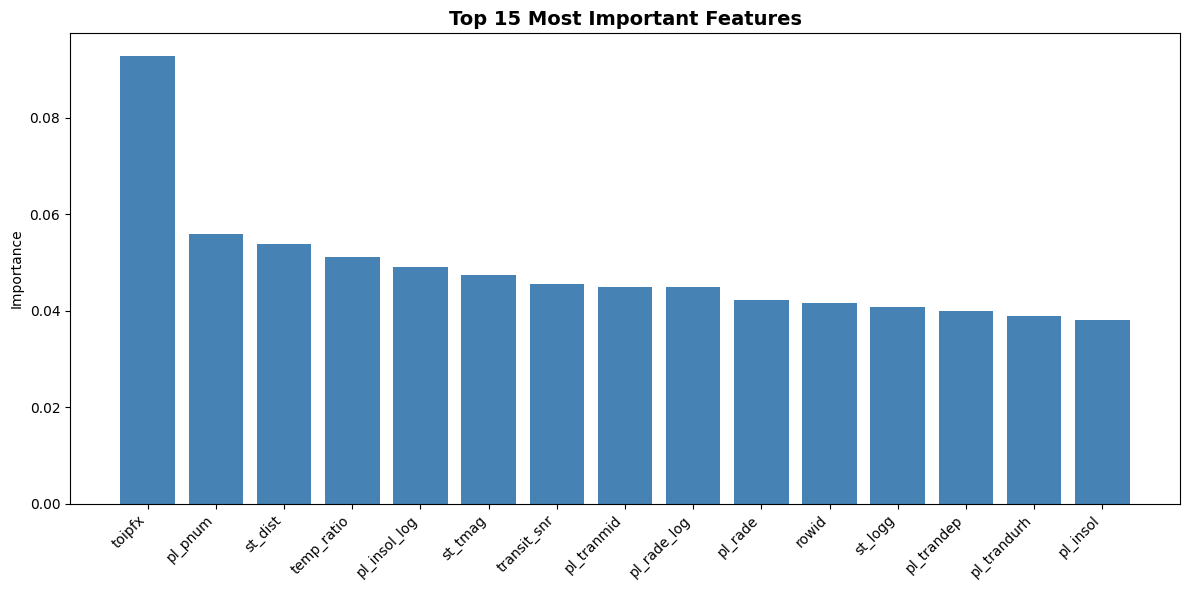

In [35]:
# 8. FEATURE IMPORTANCE
# ============================================================================

if hasattr(best_model1, 'feature_importances_'):
    print("\n" + "="*80)
    print("📊 TOP FEATURES FOR CLASSIFICATION")
    print("="*80)

    importance = best_model1.feature_importances_
    indices = np.argsort(importance)[::-1][:15]

    plt.figure(figsize=(12, 6))
    plt.title('Top 15 Most Important Features', fontweight='bold', fontsize=14)
    plt.bar(range(len(indices)), importance[indices], color='steelblue')
    plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    print("✅ Saved: feature_importance.png")

    print("\n🏆 Top 10 Features:")
    for i, idx in enumerate(indices[:10], 1):
        print(f"   {i}. {feature_cols[idx]}: {importance[idx]:.4f}")


In [36]:
# 9. SAVE ALL MODELS
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING MODELS & ARTIFACTS")
print("="*80)

# Save Stage 1 model
joblib.dump(best_model1, 'stage1_coarse_classifier.pkl')
print("✅ stage1_coarse_classifier.pkl")

# Save Stage 2 models
joblib.dump(models_stage2, 'stage2_fine_classifiers.pkl')
print("✅ stage2_fine_classifiers.pkl")

# Save scalers
joblib.dump(scaler, 'scaler_stage1.pkl')
print("✅ scaler_stage1.pkl")

# Save label encoders
joblib.dump(le_coarse, 'label_encoder_coarse.pkl')
print("✅ label_encoder_coarse.pkl")

# Save feature names
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print("✅ feature_names.txt")

# Save metadata
metadata = {
    'stage1_model': best_model1_name,
    'stage1_accuracy': float(best_acc1),
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'coarse_classes': list(le_coarse.classes_),
    'fine_classes': ['FP', 'FA', 'PC', 'APC', 'CP', 'KP'],
    'training_samples': len(df_clean)
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ model_metadata.json")



💾 SAVING MODELS & ARTIFACTS
✅ stage1_coarse_classifier.pkl
✅ stage2_fine_classifiers.pkl
✅ scaler_stage1.pkl
✅ label_encoder_coarse.pkl
✅ feature_names.txt
✅ model_metadata.json


In [37]:
print("\n" + "="*80)
print("✨ TRAINING COMPLETE!")
print("="*80)

print(f"""
🏆 RESULTS:
   Stage 1 (Coarse): {best_acc1*100:.1f}% accuracy
   Model: {best_model1_name}""")


✨ TRAINING COMPLETE!

🏆 RESULTS:
   Stage 1 (Coarse): 79.4% accuracy
   Model: XGBoost
